In [1]:
import biom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Hyperbolic geometry
from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.learning.frechet_mean import FrechetMean

# Bayesian optimization
from skopt import BayesSearchCV

# Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

INFO:root:Using numpy backend


In [2]:
# Global variables

EMBED_DIM = 128
N_SAMPLES = 1000

HYPERBOLIC = True
geom = "hyperbolic" if HYPERBOLIC else "euclidean"
EMBED_PATH = f"/home/phil/mixture/data/{EMBED_DIM}d_{geom}_otu_embeddings.csv"
MAX_ITER = 1000  # For Frechet mean

# Geometry
if HYPERBOLIC:
    hyp = Hyperbolic(dim=EMBED_DIM, default_coords_type="ball")
    fmean = FrechetMean(hyp.metric, max_iter=MAX_ITER)


In [3]:
emp_table = biom.load_table("emp/data/emp_cr_gg_13_8.release1.biom")
# This is too big to convert to a dataframe, so we need to use the biom table

# Sample metadata
sample_metadata = pd.read_table(
    "emp/data/emp_qiime_mapping_release1_20170912.tsv"
)
sample_metadata = sample_metadata.set_index("#SampleID")

# Study metadata
study_metadata = pd.read_csv("emp/data/emp_studies.csv")
study_metadata = study_metadata.drop(
    columns=study_metadata.columns[0]
)  # Blank column
study_metadata = study_metadata.set_index("study_id")


In [4]:
emp_table

# 27,398 samples and 69,901 features

69901 x 27398 <class 'biom.table.Table'> with 37193012 nonzero entries (1% dense)

In [5]:
# Exploring biom table

print(emp_table.shape)
print(emp_table.ids(axis="sample")[:10])


(69901, 27398)
['1001.SKM3' '1001.SKD6' '1001.SKM1' '1001.SKM2' '1001.SKB3' '1001.SKD3'
 '1001.SKB5' '1001.SKB2' '1001.SKB1' '1001.SKM5']


In [6]:
# Load OTU embeddings

embeddings = pd.read_csv(EMBED_PATH, dtype={0: str})
embeddings = embeddings.set_index(embeddings.columns[0])


In [7]:
# Verify there are embeddings for each sample

embedding_ids = set(embeddings.index)
emp_gg_ids = set(emp_table.ids(axis="observation"))

# Verify strict subset
assert len(emp_gg_ids - embedding_ids) == 0


In [11]:
# Generate mixture embeddings for each sample

outpath = f"emp/data/{EMBED_DIM}d_{geom}_mixture_embeddings.csv"

if os.path.exists(outpath):
    mixture_embeddings = pd.read_csv(outpath, dtype={0: str})
    mixture_embeddings = mixture_embeddings.set_index(mixture_embeddings.columns[0])

else:
    mixture_embeddings = pd.DataFrame(
        index=emp_table.ids(axis="sample"), columns=embeddings.columns
    )

    for sample_id in tqdm(emp_table.ids(axis="sample")):
        sample = emp_table.data(sample_id)
        sample = sample / sample.sum()  # Normalize
        nonzero_ids = sample.nonzero()[0]  # Indices of nonzero entries
        embed = embeddings.iloc[nonzero_ids]
        if HYPERBOLIC:
            mixture_embeddings.loc[sample_id] = fmean.fit(
                embed, weights=sample[nonzero_ids]
            ).estimate_

        else:
            mixture_embeddings.loc[sample_id] = (
                sample.values.reshape(1, -1) @ embeddings.values
            )

    mixture_embeddings.to_csv(outpath)

print("Shape:", mixture_embeddings.shape)

Shape: (27398, 128)


In [26]:
# Get distance matrix for mixture embeddings - convenient geomstats function
# Timing:
# 100 = 2s
# 1,000 = 20s
# 10,000 = crashes

N_SAMPLES = 5000

mixture_embeddings_sampled = mixture_embeddings.sample(N_SAMPLES)

mixture_dists = hyp.metric.dist_pairwise(
    mixture_embeddings_sampled.values, n_jobs=12
)

/home/phil/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


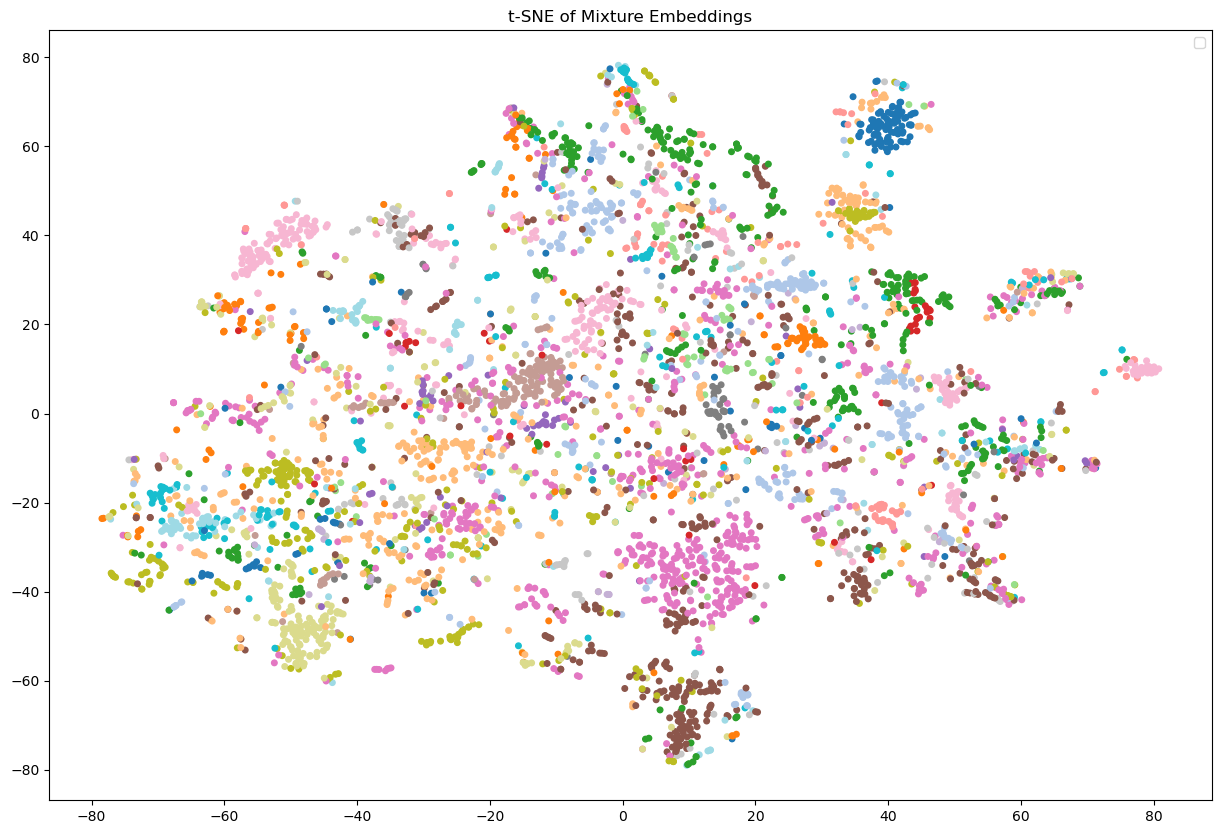

In [28]:
# t-SNE in hyperbolic space - this takes a while

tsne = TSNE(n_components=2, metric="precomputed")
tsne_embeddings = tsne.fit_transform(mixture_dists)

# Color according to study
studies = []
for sample_id in mixture_embeddings_sampled.index:
    study_id = sample_metadata.loc[sample_id]["study_id"]
    studies.append(study_metadata.loc[study_id]["title"])
colors = pd.Series(studies).astype("category").cat.codes

fig = plt.figure(figsize=(15, 10))
plt.scatter(
    tsne_embeddings[:, 0], 
    tsne_embeddings[:, 1], 
    s=16,
    c=colors,
    cmap="tab20",
)
plt.title("t-SNE of Mixture Embeddings")
plt.legend()
plt.show()

In [29]:
sample_metadata.columns

Index(['BarcodeSequence', 'LinkerPrimerSequence', 'Description',
       'host_subject_id', 'study_id', 'title', 'principal_investigator', 'doi',
       'ebi_accession', 'target_gene', 'target_subfragment', 'pcr_primers',
       'illumina_technology', 'extraction_center', 'run_center', 'run_date',
       'read_length_bp', 'sequences_split_libraries',
       'observations_closed_ref_greengenes', 'observations_closed_ref_silva',
       'observations_open_ref_greengenes', 'observations_deblur_90bp',
       'observations_deblur_100bp', 'observations_deblur_150bp',
       'emp_release1', 'qc_filtered', 'subset_10k', 'subset_5k', 'subset_2k',
       'sample_taxid', 'sample_scientific_name', 'host_taxid',
       'host_common_name_provided', 'host_common_name', 'host_scientific_name',
       'host_superkingdom', 'host_kingdom', 'host_phylum', 'host_class',
       'host_order', 'host_family', 'host_genus', 'host_species',
       'collection_timestamp', 'country', 'latitude_deg', 'longitude_deg',